<h1>Introduction</h1>

This report concerns of the pricing of Asian and Lookback options with the Monte Carlo scheme. We will be broadly following three steps:
- Simulate the risk neutral price paths of the underlying asset with the Euler-Maruyama scheme.
- Compute the option payoff for each of the price paths.
- Take the average of the payoffs discounted back to today.

<h2>Simulation of stock prices</h2>

The fair value of an option is the present value of the expected payoff at expiry under a risk-neutral random walk for
the underlying.

The risk neutral price of the stock follows:
$$
dS = rSdt + \sigma S dX
$$
Under the Euler-Maruyama Scheme, at each step
$$
\Delta S = rS\Delta t + \sigma S \sqrt{\Delta t} \phi
$$
where $\phi$ is a standard normal random variable.

In [42]:
#importing libraries
import pandas as pd
from numpy import *
#for plotting
import matplotlib.pyplot as plt
import cufflinks as cf

In [44]:
#Same function from the Monte Carlo python tutorial, except that the Euler-Maruyama scheme is used for discretisation
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):
    
    # Set the random seed for reproducibility
    # Same seed leads to the same set of random values
    random.seed(10000) 

    # Read parameters
    S0 = s0         # initial spot level
    r = mu          # mu = rf in risk neutral framework 
    T = horizon     # time horizion
    t = timesteps   # number of time steps
    n = n_sims      # number of simulation
    
    # Define dt
    dt = T/t        # length of time interval  
    
    # Simulating 'n' asset price paths with 't' timesteps
    S = zeros((t+1, n))
    S[0] = S0

    for i in range(1, t+1):
        z = random.standard_normal(n)     # psuedo random numbers
        S[i] = S[i-1] * (1 + r * dt + sigma * sqrt(dt) * z) # vectorized operation per timesteps, under Euler-Maruyama
        
    return S

<h2>Payoffs of Asian and lookback options</h2>

Asian options have payoffs that are dependant on the average price of the underlying over a certain time horizon. There are various types of Asian options: The 'average' can be arithmetic or geometric average; the average can act as the asset price or the strike price; and it can be a call or a put option(right to buy or sell).

For simplicity, here we consider a basic type of Asian option:
- a call option where the arithmetic average is used as the asset price while the strike price is fixed, $E$:
$$
(A(T) - E)^{+}
$$

Lookback options have payoffs that are dependant on the maximum or the minimum of the underlying prices.
Again, we consider a basic case of lookback option:
- a call option(to buy at the point of maximum price) where the strike price is fixed, E:
$$
(S_{max} - E)^{+}
$$

In [45]:
#Calculating payoffs from the simulated paths
#Payoff of the asian option
def asiancall(path, strike):
    a = mean(path)
    return max(a-strike, 0)
#Payoff of the lookback option
def lookbackcall(path, strike):
    m = amax(path)
    return max(m-strike, 0)
    

<h2>Discounting</h2>

Recall that the fair value of an option is given by the discounted payoff under the risk-neutral measure.
$$
V(S,t) = e^{=r(T-t)}\mathbb{E}^{\mathbb{Q}}[Payoff(S_{T})]
$$
In the Monte Carlo scheme, the expectation in risk-neutral measure is simulated by the average of payoffs calculated from every path generated with the Euler-Maruyama scheme.

In [46]:
#Taking in the payoff from each path, take the averange and discount back to t= 0
def discount(payoffs, r, T):
    return exp(-r*T)*mean(payoffs)#return the fair value of the option at t = 0

<h2>Implementation</h2>

We start from the following set of data: $S_{0} = 100$, $E = 100$, $T = 1$, $\sigma = 0.2$, $r = 0.05$
For the simulation, we use 252 steps, corresponding to 253 trading days in a year(including the start date).
10000 price paths are generated.

In [47]:
#output = [price for asian option, price for lookback option]
def monte_carlo_asian_and_lookback(s0, e, t, sigma, r, steps, n_sims):
    
    paths = simulate_path(s0, r, sigma, t, steps, n_sims)
    #Calculating payoffs
    asian_payoffs = [asiancall(paths[:,i], e) for i in range(n_sims)]
    lookback_payoffs = [lookbackcall(paths[:, j], e) for j in range(n_sims)]
    #calculating fair prices
    asian_price = discount(asian_payoffs, r, t)
    lookback_price = discount(lookback_payoffs, r, t)
    return [asian_price, lookback_price]

In [48]:
initial_prices = monte_carlo_asian_and_lookback(100, 100, 1, 0.2, 0.05, 252, 10000)
print('fair price for asian call: ', initial_prices[0], ' fair price for lookback call: ', initial_prices[1])

fair price for asian call:  5.635086451833339  fair price for lookback call:  18.103892585390913


We obtained the fair prices of both options with the original data through Monte Carlo simulation, now we change some of the data to see the affects on the results. We can see that the lookback call option is much more valuable than the asian call option, which is not surprising given that the maximum price is supposed to be always greater than the average price.

<h2>Changing underlying stock price</h2>

Now we investigate how changing the underlying stock price affects option prices. Note that it is the difference between the current stock price and the strike price that actually matters, so we wouldn't need to consider different strike prices separately. 

In [60]:
s0 = arange(75, 126)
changing_stock_price = [monte_carlo_asian_and_lookback(i, 100, 1, 0.2, 0.05, 252, 10000) for i in s0]

In [61]:
changing_stock_price_array = array(changing_stock_price)

In [63]:
print(changing_stock_price_array[:,0])

[ 0.03598195  0.05202368  0.0738252   0.10210329  0.13823739  0.18342608
  0.23837867  0.30582026  0.38711303  0.48340544  0.59778791  0.73206525
  0.88888524  1.07103882  1.27939382  1.51404032  1.77598966  2.0694373
  2.39577857  2.75369357  3.14487807  3.57052678  4.03300024  4.53254136
  5.06637537  5.63508645  6.23404763  6.86469286  7.52641484  8.21874441
  8.93768404  9.68444986 10.45541965 11.24752182 12.05916414 12.88906869
 13.7349069  14.59592951 15.47089233 16.35903032 17.25879331 18.16956641
 19.08846837 20.01531427 20.94945565 21.88979089 22.83510641 23.78465579
 24.73745616 25.69395104 26.6537836 ]


Text(0, 0.5, 'Option Value')

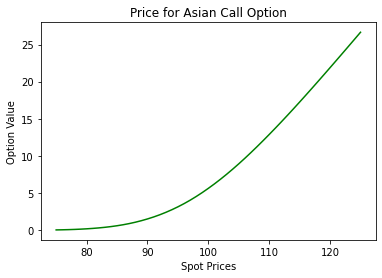

In [64]:
# plotting using matplotlib

# payoff plot for asian call option
plt.plot(s0,changing_stock_price_array[:,0],color='g')
plt.title('Price for Asian Call Option')
plt.xlabel('Spot Prices')
plt.ylabel('Option Value')

Text(0, 0.5, 'Option Value')

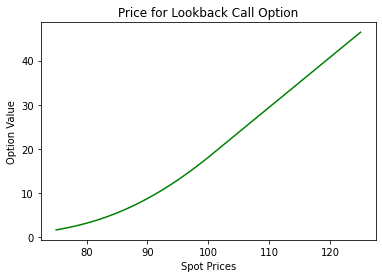

In [66]:
# payoff plot for lookback call option
plt.plot(s0,changing_stock_price_array[:,1],color='g')
plt.title('Price for Lookback Call Option')
plt.xlabel('Spot Prices')
plt.ylabel('Option Value')

We can see the values of both options increase as the stock prices increase. The values approaches 0 rapidly as they go out of money and approaches a linear relationship with the spot price as they go in the money. The gradient(delta) changes more rapidly for the asian option than the lookback option.

<h2>Changing volaitility</h2>

Now we investigate how changing volaitility affects the results.

In [72]:
sigma = arange(0, 0.4, 0.02)
changing_volaitility = array([monte_carlo_asian_and_lookback(100, 100, 1, i, 0.05, 252, 10000) for i in sigma])

Text(0, 0.5, 'Option Value')

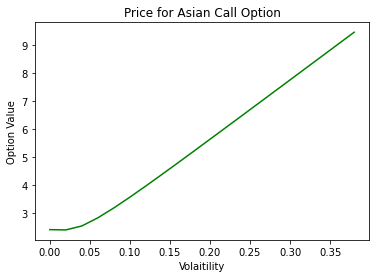

In [73]:
# payoff plot for asian call option
plt.plot(sigma,changing_volaitility[:,0],color='g')
plt.title('Price for Asian Call Option')
plt.xlabel('Volaitility')
plt.ylabel('Option Value')

Text(0, 0.5, 'Option Value')

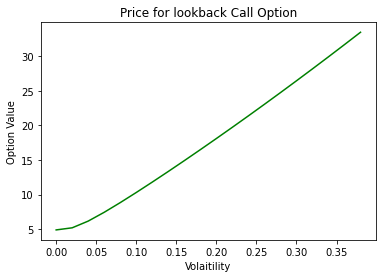

In [76]:
plt.plot(sigma,changing_volaitility[:,1],color='g')
plt.title('Price for lookback Call Option')
plt.xlabel('Volaitility')
plt.ylabel('Option Value')

The value of both options increase as volaitivity increase. This is expected as options are supposed to hedge against change in underlying prices.

<h2>Changing Interest Rate</h2>

Now we investigate how changing risk free interest rate affects the results.

In [75]:
r = arange(0, 0.1, 0.005)
changing_rates = array([monte_carlo_asian_and_lookback(100, 100, 1, 0.20, i, 252, 10000) for i in r])

Text(0, 0.5, 'Option Value')

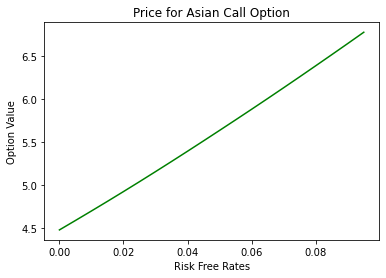

In [77]:
# payoff plot for asian call option
plt.plot(r,changing_rates[:,0],color='g')
plt.title('Price for Asian Call Option')
plt.xlabel('Risk Free Rate')
plt.ylabel('Option Value')

Text(0, 0.5, 'Option Value')

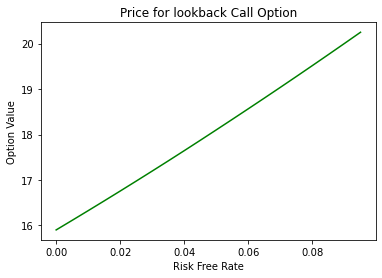

In [78]:
plt.plot(r,changing_rates[:,1],color='g')
plt.title('Price for lookback Call Option')
plt.xlabel('Risk Free Rate')
plt.ylabel('Option Value')

Both have a linear relationship with the risk free rate as expected given how we fomulate the price path with the Euler-Maruyama scheme(linear relationship with r).

<h2>Changing time horizon</h2>

Now we investigate how changing time horizon affects the results. For computational convenience, the number of steps remain unchanged even if changing time means each step no longer represent one trading date, which shouldn't affect the big picture.

In [79]:
t = arange(0.1, 2, 0.1)
changing_time = array([monte_carlo_asian_and_lookback(100, 100, i, 0.20, 0.05, 252, 10000) for i in t])

Text(0, 0.5, 'Option Value')

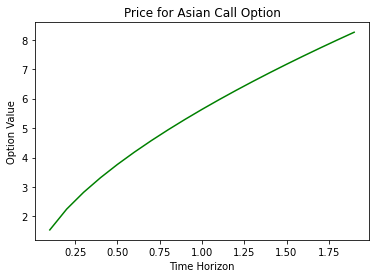

In [80]:
# payoff plot for asian call option
plt.plot(t,changing_time[:,0],color='g')
plt.title('Price for Asian Call Option')
plt.xlabel('Time Horizon')
plt.ylabel('Option Value')

Text(0, 0.5, 'Option Value')

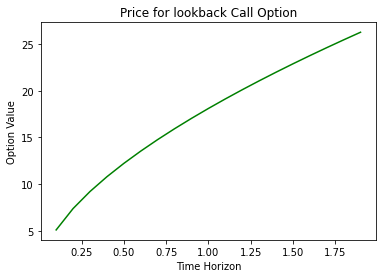

In [81]:
# payoff plot for lookback call option
plt.plot(t,changing_time[:,1],color='g')
plt.title('Price for lookback Call Option')
plt.xlabel('Time Horizon')
plt.ylabel('Option Value')

The value of the option increase as time horizon increase, as expected given the time value of money.

<h1>References</h1>

This work is mainly based on the notes from the fourth and fifth lecture in module 3 and the Monte Carlo Simulation python workshop.